In [14]:
import os
from azure.core.credentials import AzureKeyCredential
from azure.ai.documentintelligence import DocumentIntelligenceClient
from azure.ai.documentintelligence.models import AnalyzeResult
from azure.ai.documentintelligence.models import AnalyzeDocumentRequest
from PIL import Image, ImageDraw, ImageFont
import math
import openai
from openai import AzureOpenAI
from dotenv import load_dotenv
import cv2
from modelscope.outputs import OutputKeys
from modelscope.pipelines import pipeline
from modelscope.utils.constant import Tasks


/Users/zouang/code/honor/ImageTranslator/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
endpoint = os.environ.get("AZURE_DOCUMENT_INTELLIGENCE_ENDPOINT")
key = os.environ.get("AZURE_DOCUMENT_INTELLIGENCE_SUBSCRIPTION_KEY")

azure_openai_api_endpoint = os.environ.get("AZURE_OPENAI_API_ENDPOINT")
azure_openai_api_key = os.environ.get("AZURE_OPENAI_API_KEY")
azure_openai_api_version = os.environ.get("AZURE_OPENAI_API_VERSION")
model = os.environ.get("AZURE_OPENAI_MODEL")

In [3]:
image_path = "./WechatIMG91.jpg"

In [4]:
pil_image = Image.open(image_path)

In [5]:
pil_image.width, pil_image.height

(694, 920)

In [13]:
def get_words(page, line):
    result = []
    for word in page.words:
        if _in_span(word, line.spans):
            result.append(word)
    return result


# To learn the detailed concept of "span" in the following codes, visit: https://aka.ms/spans 
def _in_span(word, spans):
    for span in spans:
        if word.span.offset >= span.offset and (word.span.offset + word.span.length) <= (span.offset + span.length):
            return True
    return False

def analyze_layout(image_path: str):

    document_intelligence_client = DocumentIntelligenceClient(
        endpoint=endpoint, credential=AzureKeyCredential(key)
    )

    with open(image_path, "rb") as f:
        poller = document_intelligence_client.begin_analyze_document(
            "prebuilt-read", analyze_request=f, content_type="application/octet-stream"
        )

    result: AnalyzeResult = poller.result()
    translate_keywords = []

    if result.styles:
        for style in result.styles:
            if style.is_handwritten:
                print("Found the following handwritten content: ")
                print(",".join([result.content[span.offset : span.offset + span.length] for span in style.spans]))
            if style.font_style:
                print(f"The document contains '{style.font_style}' font style, applied to the following text: ")
                print(",".join([result.content[span.offset : span.offset + span.length] for span in style.spans]))

    for page in result.pages:
        print(f"----Analyzing layout from page #{page.page_number}----")
        print(
            f"Page has width: {page.width} and height: {page.height}, measured with unit: {page.unit}"
        )

        if page.lines:
            for line_idx, line in enumerate(page.lines):
                words = get_words(page, line)
                print(
                    f"...Line # {line_idx} has word count {len(words)} and text '{line.content}' "
                    f"within bounding polygon '{line.polygon}'"
                )
                translate_keywords.append((line.content, line.polygon))

                for word in words:
                    print(
                        f"......Word '{word.content}' has a confidence of {word.confidence}"
                    )

        if page.selection_marks:
            for selection_mark in page.selection_marks:
                print(
                    f"Selection mark is '{selection_mark.state}' within bounding polygon "
                    f"'{selection_mark.polygon}' and has a confidence of {selection_mark.confidence}"
                )

    if result.tables:
        for table_idx, table in enumerate(result.tables):
            print(
                f"Table # {table_idx} has {table.row_count} rows and "
                f"{table.column_count} columns"
            )
            if table.bounding_regions:
                for region in table.bounding_regions:
                    print(
                        f"Table # {table_idx} location on page: {region.page_number} is {region.polygon}"
                    )
            for cell in table.cells:
                print(
                    f"...Cell[{cell.row_index}][{cell.column_index}] has text '{cell.content}'"
                )
                if cell.bounding_regions:
                    for region in cell.bounding_regions:
                        print(
                            f"...content on page {region.page_number} is within bounding polygon '{region.polygon}'"
                        )

    print("----------------------------------------")
    return translate_keywords

def translate_using_gpt(text, translate_to_language):
    azure_openai_client = AzureOpenAI(azure_endpoint=azure_openai_api_endpoint, api_key=azure_openai_api_key, api_version=azure_openai_api_version)
    messages = [
        {
            "role": "system",
            "content": "You are a translator to help translate the text into " + translate_to_language + ". Only translate the text, do not add any additional information. If you can't translate the text, output original text."
        },{
            "role": "user",
            "content": f"translate the following text into {translate_to_language}: "+text
        }
    ]
    result = azure_openai_client.chat.completions.create(
                model=model,
                messages=messages,
                temperature=0
            )
    return result.choices[0].message.content

In [7]:
result = translate_using_gpt("玉萍烟酒行", "English")

In [8]:
result

'Yu Ping Tobacco and Alcohol Shop'

In [9]:
analyze_layout("./WechatIMG91.jpg")

----Analyzing layout from page #1----
Page has width: 694 and height: 920, measured with unit: LengthUnit.PIXEL
...Line # 0 has word count 5 and text '玉萍烟酒行' within bounding polygon '[203, 302, 592, 355, 590, 443, 192, 398]'
......Word '玉' has a confidence of 0.995
......Word '萍' has a confidence of 0.996
......Word '烟' has a confidence of 0.995
......Word '酒' has a confidence of 0.996
......Word '行' has a confidence of 0.996
----------------------------------------


[('玉萍烟酒行', [203, 302, 592, 355, 590, 443, 192, 398])]

In [101]:
def replace_text_with_translation(image_path, translate_keywords):
    image = Image.open(image_path)
    draw = ImageDraw.Draw(image)
    for keyword, polygon in translate_keywords:
        # tim = Image.new('RGBA', image.size, (0,0,0,0))
        # draw = ImageDraw.Draw(tim)
        translated_text = translate_using_gpt(keyword, "English")
        draw.polygon(polygon,fill="grey")
        # font = ImageFont.truetype("arial.ttf", 15)
        font= ImageFont.load_default()
        text_size = draw.textlength(translated_text, font=font)
        print("original text size: ", text_size)
        max_text_width = abs(polygon[0] - polygon[2])
        scaling_factor = max_text_width / text_size
        scaled_font_size = font.size * scaling_factor
        if scaled_font_size <= 0:
            scaled_font_size = text_size
        print("scaled font size: ", scaled_font_size)
        scaled_font = ImageFont.truetype('Arial_Unicode.ttf', size=scaled_font_size)
        # polygon is [202, 308, 591, 360, 586, 447, 195, 397]
        # calculate the angle of the text
        degrees = math.degrees(math.atan2(polygon[3] - polygon[1], polygon[2] - polygon[0]))
        print(-degrees)
        shear = math.tan(math.radians(degrees))
        # draw.text((polygon[0], polygon[0].y), translated_text, fill="red")
        # coords = ((polygon[0], polygon[1]), (polygon[0] + len(translated_text) * 10, polygon[1] + font.getlength(translated_text)))
        coords = (polygon[0], polygon[1])
        draw.textbox(coords, translated_text, rotate=-45, fill="red", font=scaled_font)
        # image.paste(draw, (0, 0, 0, 0), draw)
    image.save("translated_image.jpg")
    return image

In [39]:
degrees = 45


shear = math.tan(math.radians(degrees))

In [40]:
shear

0.9999999999999999

In [75]:
def translate_image(image_path):
    translate_keywords = analyze_layout(image_path)
    return replace_text_with_translation(image_path, translate_keywords)

In [61]:
new_image = ImageDraw.Draw(pil_image)
box = [202, 308, 591, 360, 586, 447, 195, 397]
new_image.polygon([202, 308, 591, 360, 586, 447, 195, 397], outline="red", width=1)
new_image.polygon([400, 618, 400, 608, 408, 608, 408, 618], outline="yellow", width=1)
new_image.circle((202, 308), fill="red", radius=10)
new_image.circle((591, 360), fill="green", radius=10)
new_image.circle((586, 447), fill="blue", radius=10)
new_image.circle((195, 397), fill="yellow", radius=10)

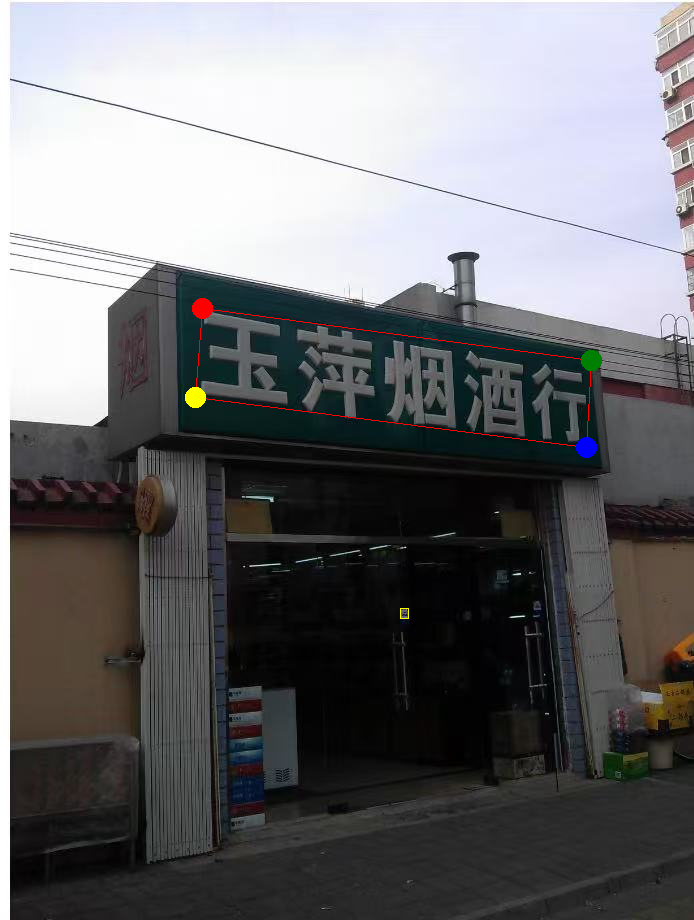

In [62]:
pil_image

In [102]:
translated_image = translate_image(image_path)

Document does not contain handwritten content
----Analyzing layout from page #1----
Page has width: 694 and height: 920, measured with unit: LengthUnit.PIXEL
...Line # 0 has word count 5 and text '玉萍烟酒行' within bounding polygon '[202, 308, 591, 360, 586, 447, 195, 397]'
......Word '玉' has a confidence of 0.993
......Word '萍' has a confidence of 0.995
......Word '烟' has a confidence of 0.996
......Word '酒' has a confidence of 0.995
......Word '行' has a confidence of 0.995
...Line # 1 has word count 1 and text '2' within bounding polygon '[400, 618, 400, 608, 408, 608, 408, 618]'
......Word '2' has a confidence of 0.753
----------------------------------------
original text size:  153.0
scaled font size:  25.424836601307188
-7.613938124391143
original text size:  6.0
scaled font size:  6.0
90.0


In [26]:
font = ImageFont.load_default_imagefont()

In [107]:
translated_image.show()

In [105]:
colors = translated_image.getcolors()

In [106]:
colors